In [38]:
import sys
sys.path.append("../src")

import galois
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tqdm

import controlled
import distributed
import common

In [4]:
def random_invertible_matrix(n: int) -> galois.FieldArray:
    # Constant expected time, probability of A being invertible is always more than 0.25 regardless of n
    while True:
        A = galois.GF2.Random((n, n))
        if np.linalg.matrix_rank(A) == n:
            return A

In [53]:
data_dist = []
for size in range(4, 128, 2):
    samples = []
    for _ in tqdm.trange(10, desc=str(size)):
        A = random_invertible_matrix(size)
        gates_gauss = common.synth_gauss(A)
        nl_gauss = sum(1 for i, j in gates_gauss if (i < size//2) ^ (j < size//2))
        gates_rank = distributed.synth_distributed(A, size//2)
        nl_rank = sum(1 for i, j in gates_rank if (i < size//2) ^ (j < size//2))
        samples.append((size, len(gates_gauss), nl_gauss, len(gates_rank), nl_rank))
    data_dist.append(samples)
data_dist = np.array(data_dist)

126: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


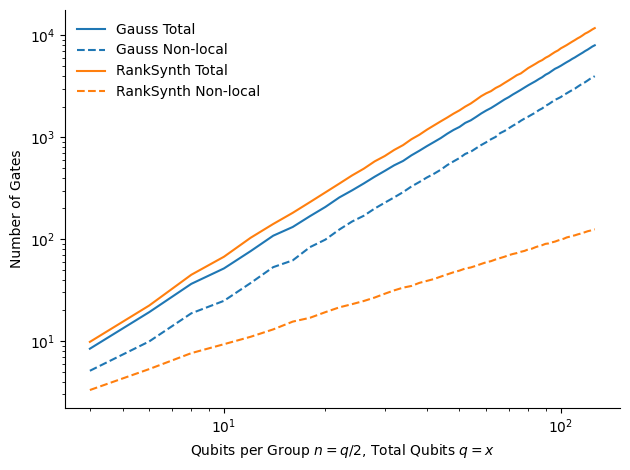

In [100]:
plt.plot(data_dist[:, :, 0].mean(axis=1), data_dist[:, :, 1].mean(axis=1), 'C0-', label="Gauss Total")
plt.plot(data_dist[:, :, 0].mean(axis=1), data_dist[:, :, 2].mean(axis=1), 'C0--', label="Gauss Non-local")
plt.plot(data_dist[:, :, 0].mean(axis=1), data_dist[:, :, 3].mean(axis=1), 'C1-', label="RankSynth Total")
plt.plot(data_dist[:, :, 0].mean(axis=1), data_dist[:, :, 4].mean(axis=1), 'C1--', label="RankSynth Non-local")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Qubits per Group $n = q/2$, Total Qubits $q = x$")
plt.ylabel("Number of Gates")
plt.legend(frameon=False)
seaborn.despine()
plt.tight_layout()
plt.savefig("plots/distributed_loglog_comparison.png", dpi=300)

In [59]:
data_dist_split = []
for split in range(1, 32):
    samples = []
    for _ in tqdm.trange(10, desc=str(split)):
        A = random_invertible_matrix(32)
        gates_gauss = common.synth_gauss(A)
        nl_gauss = sum(1 for i, j in gates_gauss if (i < split) ^ (j < split))
        gates_rank = distributed.synth_distributed(A, split)
        nl_rank = sum(1 for i, j in gates_rank if (i < split) ^ (j < split))
        samples.append((split, len(gates_gauss), nl_gauss, len(gates_rank), nl_rank))
    data_dist_split.append(samples)
data_dist_split = np.array(data_dist_split)

31: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


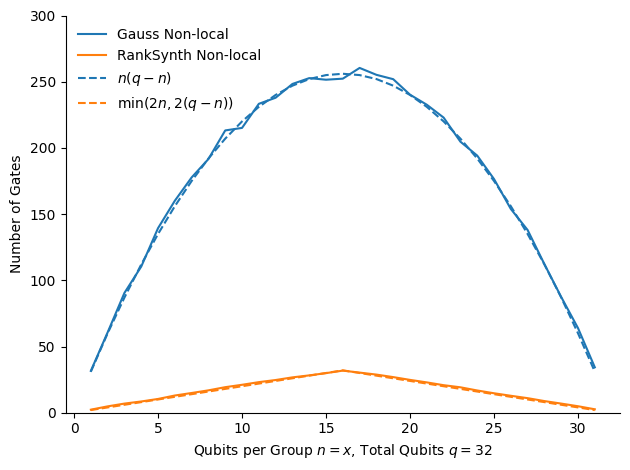

In [84]:

plt.plot(data_dist_split[:, :, 0].mean(axis=1), data_dist_split[:, :, 2].mean(axis=1), 'C0-', label="Gauss Non-local")
plt.plot(data_dist_split[:, :, 0].mean(axis=1), data_dist_split[:, :, 4].mean(axis=1), 'C1-', label="RankSynth Non-local")
plt.plot(data_dist_split[:, :, 0].mean(axis=1), data_dist_split[:, :, 0].mean(axis=1)*(32-data_dist_split[:, :, 0].mean(axis=1)), "C0--", label="$n(q - n)$")
plt.plot(data_dist_split[:, :, 0].mean(axis=1), 2*np.minimum(data_dist_split[:, :, 0].mean(axis=1), (32-data_dist_split[:, :, 0].mean(axis=1))), "C1--", label="$\\min(2n, 2(q-n))$")
plt.xlabel("Qubits per Group $n = x$, Total Qubits $q = 32$")
plt.ylabel("Number of Gates")
plt.legend(loc="upper left", frameon=False)
plt.ylim(0, 300)
seaborn.despine()
plt.tight_layout()
plt.savefig("plots/distributed_split_comparison.png", dpi=300)

In [106]:
data_cont = []
for size in range(4, 64, 4):
    samples = []
    for _ in tqdm.trange(10, desc=str(size)):
        A = random_invertible_matrix(size)
        gates_gauss = common.synth_gauss(A)
        gates_rcf = controlled.synthesize_controlled_cnot(gates_gauss)
        toff_rcf = sum(1 for g in gates_rcf if len(g) == 3)
        cnot_rcf = sum(1 for g in gates_rcf if len(g) == 2)
        samples.append((size, len(gates_gauss), cnot_rcf, toff_rcf))
    data_cont.append(samples)
data_cont = np.array(data_cont)

60: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


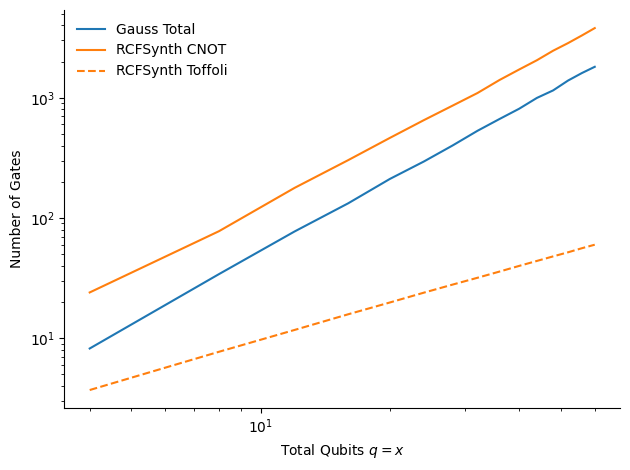

In [108]:
plt.plot(data_cont[:, :, 0].mean(axis=1), data_cont[:, :, 1].mean(axis=1), 'C0-', label="Gauss Total")
plt.plot(data_cont[:, :, 0].mean(axis=1), data_cont[:, :, 2].mean(axis=1), 'C1-', label="RCFSynth CNOT")
plt.plot(data_cont[:, :, 0].mean(axis=1), data_cont[:, :, 3].mean(axis=1), 'C1--', label="RCFSynth Toffoli")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Total Qubits $q = x$")
plt.ylabel("Number of Gates")
plt.legend(frameon=False)
seaborn.despine()
plt.tight_layout()
plt.savefig("plots/controlled_loglog_comparison.png", dpi=300)